# DDoS Detection Using Convolutional Neural Networks (CNNs)

## Overview
This Jupyter notebook implements a DDoS (Distributed Denial of Service) detection model using Convolutional Neural Networks (CNNs). The code encompasses data loading, preprocessing, model building, training, evaluation, and result visualization.

![Alt text](Images/DDoS_Attack.png)

In [1]:
# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
#import libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD,Adam
import keras
# Conv1D + LSTM
from keras.layers import Conv1D,MaxPooling1D
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from keras.layers import Flatten

2024-02-21 14:03:39.815686: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 14:03:39.847797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 14:03:39.847836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 14:03:39.847856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-21 14:03:39.853750: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-21 14:03:39.854166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
# Reading Data

In [4]:
col_list = ["sport","dport", 
            "pkts","bytes", 
            "state","dur", 
            "mean","stddev", 
            "sum","min", 
            "max","spkts", 
            "dpkts","sbytes", 
            "dbytes","rate", 
            "srate","drate",
            "attack"
           ]

In [5]:
df_num=pd.read_csv('./DDoS_TCP.csv',sep=';',usecols=col_list)#nrows=50000,
print(df_num)

            sport  dport   pkts    bytes state        dur      mean    stddev  \
0          3456.0   80.0  10242  9972888   CON  75.066856  4.989200  0.006723   
1          8080.0   80.0  10246  9978140   CON  75.066925  4.989192  0.006743   
2            80.0   80.0   5116  4911913   INT  75.063446  4.990958  0.005609   
3            80.0   80.0   5117  4789010   CON  75.063515  4.990964  0.003873   
4           365.0  565.0   2753   165180   INT  75.240524  4.954834  0.048765   
...           ...    ...    ...      ...   ...        ...       ...       ...   
19548230  42343.0   80.0      1      154   REQ   0.000000  0.000000  0.000000   
19548231  42344.0   80.0      1      154   REQ   0.000000  0.000000  0.000000   
19548232  42345.0   80.0      1      154   REQ   0.000000  0.000000  0.000000   
19548233      NaN    NaN      5      300   CON   3.098834  3.098834  0.000000   
19548234      NaN    NaN      3      180   CON   1.032404  1.032404  0.000000   

                sum       m

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, metrics
cat_features = ['state']
encoder = LabelEncoder()
label_encoder = preprocessing.LabelEncoder()
for feature in cat_features:
    encoded = label_encoder.fit_transform(df_num[cat_features])
    df_num['state'] = encoded

/home/f20201769/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
len(df_num)

19548235

In [8]:
# Data Preparation

In [9]:
df_num.dtypes

sport     float64
dport     float64
pkts        int64
bytes       int64
state       int64
dur       float64
mean      float64
stddev    float64
sum       float64
min       float64
max       float64
spkts       int64
dpkts       int64
sbytes      int64
dbytes      int64
rate      float64
srate     float64
drate     float64
attack      int64
dtype: object

In [10]:
### Removing nan values

In [11]:
print(df_num.isna().sum().sum())
df_num=df_num.dropna()
print(df_num.isna().sum().sum())

1022
0


In [12]:
df_num.sample(5)

,sport,dport,pkts,bytes,state,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
11245512,47075.0,80.0,1,154,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,154,0,0.000000,0.000000,0.0,1
3159755,26237.0,80.0,4,616,5,27.988871,0.000000,0.000000,0.000000,0.000000,0.000000,4,0,616,0,0.107185,0.107185,0.0,1
9227879,52093.0,80.0,5,770,5,23.883755,1.144956,1.983122,4.579824,0.000000,4.579824,5,0,770,0,0.167478,0.167478,0.0,1
14343774,1361.0,80.0,4,522,7,35.058750,0.011763,0.016636,0.035290,0.000000,0.035290,3,1,462,60,0.085571,0.057105,0.0,1
757989,44669.0,80.0,4,616,5,9.548336,3.210579,0.118540,6.421158,3.092042,3.329116,4,0,616,0,0.314191,0.314191,0.0,1


In [13]:
# Distribution Classes

In [14]:
df_num.groupby('attack').size()

attack
0         620
1    19547104
dtype: int64

In [15]:
# Remove Useless Features

In [16]:
for col in (df_num.iloc[:,:-1].columns):
    if(df_num[col].min()==df_num[col].max()):
            df_num.drop(col, axis=1, inplace=True)

In [17]:
# Feature Scaling

In [18]:
# Normalization OR Standardization
def standardize(df,col):
    df[col]= (df[col]-df[col].mean())/(df[col].std()) # Standardization
    #df[col]= (df[col]-df[col].min())/(df[col].max()-df[col].min()) #Normalization

for i in (df_num.iloc[:,:-1].columns):
    standardize (df_num,i)

df_num.head()

,sport,dport,pkts,bytes,state,dur,mean,stddev,sum,min,max,spkts,dpkts,sbytes,dbytes,rate,srate,drate,attack
0,-1.548194,-0.037286,675.736035,703.160651,-5.246894,3.957576,2.468846,-0.842947,20.190914,3.146913,1.296183,505.592497,786.258320,540.080391,805.656119,58.227191,119.466340,195.626713,0
1,-1.303736,-0.037286,676.000054,703.530979,-5.246894,3.957581,2.468840,-0.842925,20.190879,3.146903,1.296216,505.395001,787.180137,570.688614,762.784607,58.249946,119.419450,195.855940,0
2,-1.726673,-0.037286,337.396105,346.302181,-2.882854,3.957337,2.470041,-0.844178,20.198370,3.158983,1.296184,504.802514,-0.051547,543.889267,-0.005093,28.999581,119.284684,-0.021749,0
3,-1.726673,-0.037286,337.462110,337.636069,-5.246894,3.957342,2.470045,-0.846095,20.198394,3.158984,1.296184,504.901262,-0.051547,530.278685,-0.005093,29.005256,119.307963,-0.021749,0
4,-1.711606,0.261762,181.427074,11.601481,-2.882854,3.969784,2.445479,-0.796511,20.045182,3.044447,1.294951,271.461374,-0.051547,18.224300,-0.005093,15.487984,63.869466,-0.021749,0


In [19]:
target=['attack']
features = [c for c in df_num.columns if c!="attack"]

In [20]:
# Split DataSet

In [21]:
X = df_num[features].values # Features
y = df_num[target].values # Target

X=X.astype(np.float32)
y=y.astype(np.float32)

X.shape,y.shape,

((19547724, 18), (19547724, 1))

In [22]:
del df_num

In [23]:
gc.collect()

43

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [25]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15638179, 18), (3909545, 18), (15638179, 1), (3909545, 1))

In [26]:
X_train_cnn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test_cnn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
print(X_train_cnn.shape)
print(X_test_cnn.shape)


(15638179, 18, 1)
(3909545, 18, 1)


In [27]:
# Build CNN Model

In [28]:
learning_rate=0.001
batch_size=5000
epochs = 1

model_save = ModelCheckpoint('./DDoS_TCP.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, 
                           patience = 8, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.6, 
                              patience = 4, min_delta = 0.0001, 
                              mode = 'min', verbose = 1)

In [29]:
X_test.shape[1]

18

In [30]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

In [31]:
model = Sequential()
model.add(Conv1D(16,2,input_shape = (X_test.shape[1], 1)))
model.add(Conv1D(16,2))
model.add(MaxPooling1D(1))


model.add(Conv1D(32,2))
model.add(Conv1D(32,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(64,2))
model.add(Conv1D(64,2))
model.add(MaxPooling1D(1))

model.add(Conv1D(128,2))
model.add(Conv1D(128,2))
model.add(MaxPooling1D(1))

#model.add(LSTM(32, activation = 'relu', return_sequences=True))
#model.add(LSTM(16, return_sequences=True))  # returns a sequence of vectors of dimension 16
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=learning_rate)
#model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=[keras.metrics.AUC(name='auc')])

print(model.summary())

from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Sequential Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)



history = model.fit(X_train_cnn,
                    y_train,
                    batch_size=batch_size,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(X_test_cnn,y_test),
                    callbacks = [model_save, early_stop, reduce_lr],)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 16)            48        
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            528       
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 16)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 32)            1056      
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 32)            2080      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 32)            0         
 g1D)                                                   

2024-02-21 14:04:25.542453: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


None
3127/3127 [==============================] - ETA: 0s - loss: 0.0020 - auc: 0.9237
Epoch 1: val_loss improved from inf to 0.00046, saving model to ./DDoS_TCP.h5
3127/3127 [==============================] - 613s 195ms/step - loss: 0.0020 - auc: 0.9237 - val_loss: 4.6209e-04 - val_auc: 0.9179 - lr: 0.0010


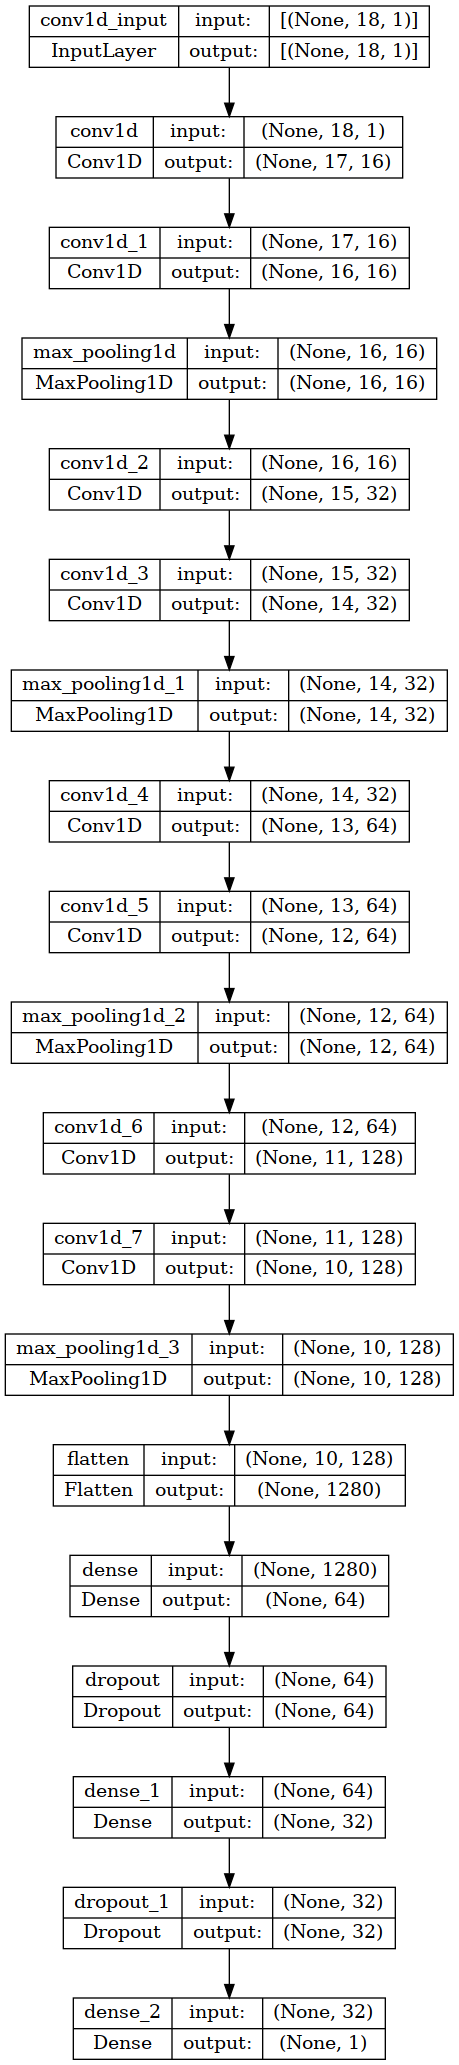

In [32]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Sequential Keras model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [33]:
# Evaluation

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 17, 16)            48        
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 16)            528       
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 16)            0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 15, 32)            1056      
                                                                 
 conv1d_3 (Conv1D)           (None, 14, 32)            2080      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 14, 32)            0         
 g1D)                                                   

In [35]:
y_pred = model.predict(X_test_cnn, batch_size=512)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

7636/7636 [==============================] - 47s 6ms/step
AUC: 0.922


In [36]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv('history.csv')

In [37]:
### Training Curves

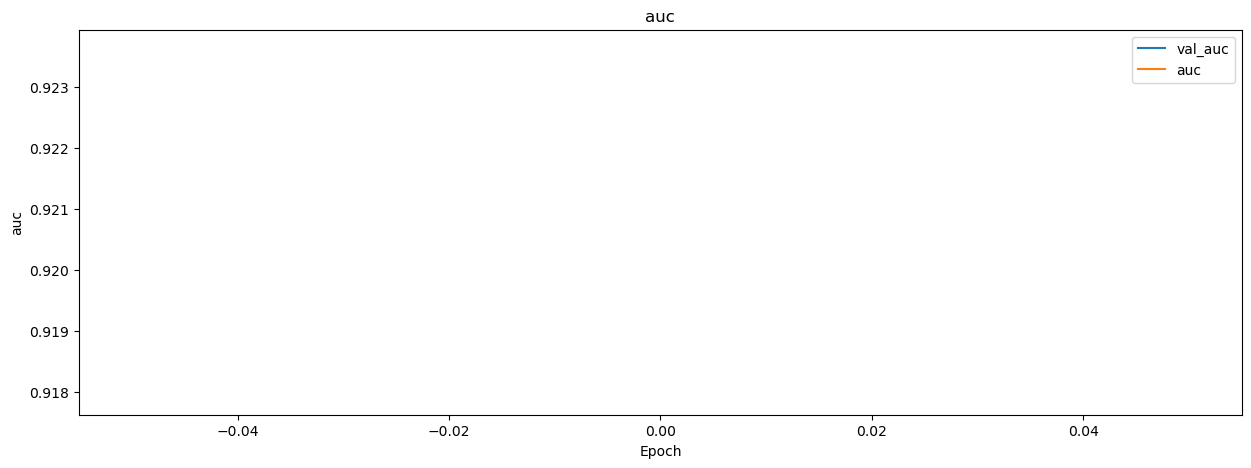

In [38]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_auc'],label='val_auc')
plt.plot(range(history.epoch[-1]+1),history.history['auc'],label='auc')
plt.title('auc'); plt.xlabel('Epoch'); plt.ylabel('auc');plt.legend(); 
plt.show()

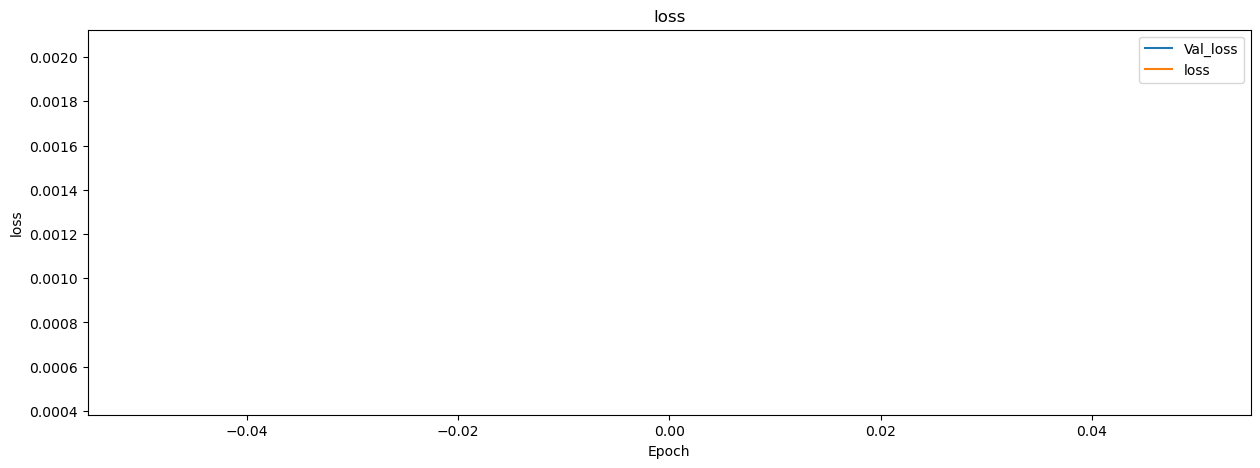

In [39]:
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_loss'],label='Val_loss')
plt.plot(range(history.epoch[-1]+1),history.history['loss'],label='loss')
plt.title('loss'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend(); 
plt.show()

In [40]:
### ROC Curve

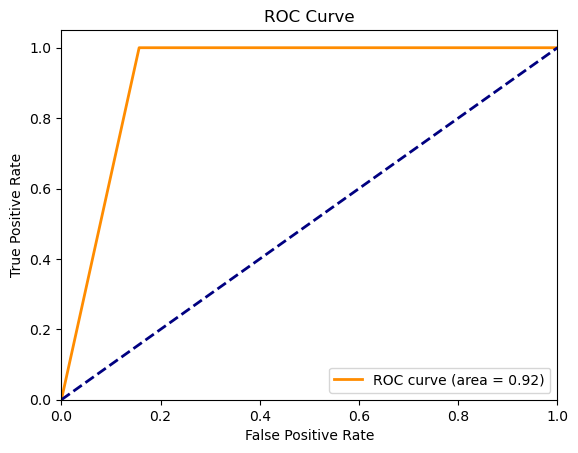

In [41]:
def generate_results(y_test, y_score):
    # print(y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
generate_results(y_test, y_pred)